In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from src.ml_utils import fetch_daily_ohlcv

In [2]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHASEA_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_daily_ohlcv(symbols=symbols, with_target=True)
df.to_pickle('/tmp/df.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 00:00:00+00:00 BNB        29.074200     31.555300     28.937300   
                          BTC     10532.400561  11094.361621  10385.558949   
                          ETH       221.191514    235.735515    220.461791   
                          XRP         0.319763      0.341772      0.319140   
2019-07-21 00:00:00+00:00 BNB        31.135900     31.551650     29.352900   
...                                        ...           ...           ...   
2022-01-18 00:00:00+00:00 ETH      3213.081008   3242.884085   3086.126342   
                          LINK       23.847289     24.330571     22.062799   
                          MATIC       2.219229      2.245212      2.080268   
                          SOL       139.948711    142.588944    134.457502   
                          XRP         0.762366      0.768328      0.736754   

                                            cl        execution_start_at  \
timestamp                 symbol                                           
2019-07-20 00:00:00+00:00 BNB        31.135900 2019-07-21 00:30:00+00:00   
                          BTC     10758.259167 2019-07-21 00:30:00+00:00   
                          ETH       229.000753 2019-07-21 00:30:00+00:00   
                          XRP         0.333653 2019-07-21 00:30:00+00:00   
2019-07-21 00:00:00+00:00 BNB        30.417250 2019-07-22 00:30:00+00:00   
...                                        ...                       ...   
2022-01-18 00:00:00+00:00 ETH      3161.816801 2022-01-19 00:30:00+00:00   
                          LINK       22.981037 2022-01-19 00:30:00+00:00   
                          MATIC       2.120582 2022-01-19 00:30:00+00:00   
                          SOL       141.246563 2022-01-19 00:30:00+00:00   
                          XRP         0.751582 2022-01-19 00:30:00+00:00   

                                       ret  
timestamp                 symbol            
2019-07-20 00:00:00+00:00 BNB    -0.036594  
                          BTC    -0.019768  
                          ETH    -0.018317  
                          XRP    -0.015445  
2019-07-21 00:00:00+00:00 BNB    -0.001055  
...                                    ...  
2022-01-18 00:00:00+00:00 ETH          NaN  
                          LINK         NaN  
                          MATIC        NaN  
                          SOL          NaN  
                          XRP          NaN  

[7978 rows x 6 columns]

In [3]:
def calc_features(df):
    df = df.copy()
    
    df['feature_1'] = (df['cl'] / df.groupby('symbol')['cl'].shift(1) - 1).fillna(0)
    df['feature_2'] = (df['cl'] / df.groupby('symbol')['cl'].shift(2) - 1).fillna(0)
    df['feature_3'] = (df['cl'] / df.groupby('symbol')['cl'].shift(3) - 1).fillna(0)
    df['feature_4'] = (df['cl'] / df.groupby('symbol')['cl'].shift(4) - 1).fillna(0)

    return df

def get_feature_columns(df):
    return sorted(df.columns[df.columns.str.startswith('feature')].to_list())

df = pd.read_pickle('/tmp/df.pkl')
df = calc_features(df)
df = df.dropna()
df.to_pickle('/tmp/df_features.pkl')

(0.08615935234738917, 1.318503329340349e-14)


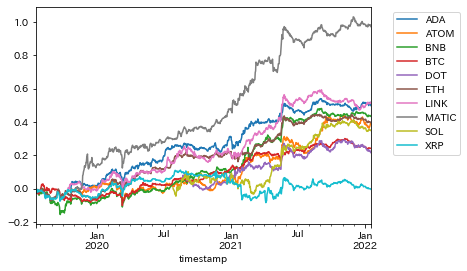

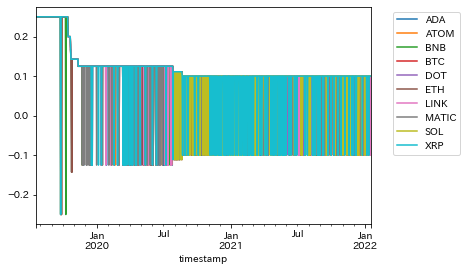

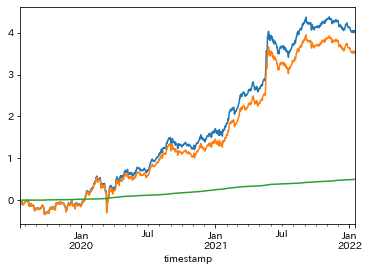

In [4]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

df = pd.read_pickle('/tmp/df_features.pkl')
features = get_feature_columns(df)

model = Ridge()

df['y_pred'] = cross_val_predict(
    model,
    df[features],
    df['ret'],
)
df['pos'] = np.sign(df['y_pred'])

# normalize position
df['pos_abs'] = df['pos'].abs()
df['pos'] /= df.groupby('timestamp')['pos_abs'].transform('sum')

df['ret_pos'] = df['ret'] * df['pos']
execution_cost = 0.001
df['cost'] = (df['pos'] - df.groupby('symbol')['pos'].shift(1)).fillna(0).abs() * execution_cost
df['ret_pos_cost'] = df['ret_pos'] - df['cost']

print(pearsonr(df['ret'], df['y_pred']))

for symbol, df_symbol in df.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    df_symbol['ret_pos'].cumsum().plot(label=symbol)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

for symbol, df_symbol in df.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    df_symbol['pos'].plot(label=symbol)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.groupby('timestamp')['ret_pos'].sum().cumsum().plot()
df.groupby('timestamp')['ret_pos_cost'].sum().cumsum().plot()
df.groupby('timestamp')['cost'].sum().cumsum().plot()
plt.show()

In [6]:
class PortableModel:
    def __init__(self, model):
        self._model = model
    
    def predict(self, df):
        df = calc_features(df)
        features = get_feature_columns(df)
        return self._model.predict(df[features])

df = pd.read_pickle('/tmp/df_features.pkl')
features = get_feature_columns(df)
model.fit(df[features], df['ret'])

portable_model = PortableModel(model)
data = cloudpickle.dumps(portable_model)
data = lzma.compress(data)
with open(os.getenv('ALPHASEA_MODEL_PATH'), 'wb') as f:
    f.write(data)

In [1]:
# model validation
import os
import joblib
import pandas as pd

portable_model = joblib.load(os.getenv('ALPHASEA_MODEL_PATH'))
df = pd.read_pickle('/tmp/df.pkl')
df = df[['op', 'hi', 'lo', 'cl']]
print(portable_model.predict(df))

[0.00567583 0.00567583 0.00567583 ... 0.00810134 0.00315915 0.00657258]
